In [63]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import tables


from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

np.random.seed(seed=1)
L.seed_everything(seed=1, workers=True)

[rank: 0] Seed set to 1


1

### Define the list of variables from the h5 file to use as features, spectator and labels

In [64]:
# 27 features
features = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [65]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    return feature_array, label_array

In [66]:
# copy training file if it doesn't exist
import os.path
if not os.path.isfile('dataset/ntuple_merged_10.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .

# load training file
feature_array, label_array = get_features_labels('dataset/ntuple_merged_10.h5', remove_mass_pt_window=False)

In [67]:
feature_array[0]
feature_array[0].size

27

In [68]:
label_array[0]

array([1., 0.])

In [69]:
# Divide train and validation+test
X_train, X_temp, y_train, y_temp = train_test_split(feature_array, label_array, test_size=0.2, random_state=42, shuffle=True)

# Divide validation+test in validation and test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Load the data (numpy.array) into a DatasetLoad (Tensor)

In [70]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [71]:
ae_train_ds = SensorDataset(X_train)
ae_valid_ds = SensorDataset(X_valid)
ae_test_ds = SensorDataset(X_test)

In [72]:
ae_train_ds[2]

tensor([ 9.0000,  0.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.6387,
         0.3277,  1.8854,  3.1842,  1.4477,  1.4063,  1.4477,  3.1842,  0.3413,
         1.4063,  1.0664, -3.0000])

In [78]:
class Autoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.mse_loss(output, input)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.mse_loss(output, input)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        output = self.forward(input)
        return output

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-3)

#### PyTorch Progress Bar Implementation

In [79]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

In [84]:
in_dim = ae_train_ds.dataset.shape[1]
model = Autoencoder(in_dim)

batch_size = 32
ae_tdl, ae_vdl = DataLoader(ae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(ae_valid_ds, batch_size=batch_size, num_workers=4)

In [85]:
es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()
trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=1_000, logger=False, enable_checkpointing=True, accelerator="cpu")
trainer.fit(model, train_dataloaders=ae_tdl, val_dataloaders=ae_vdl)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 1.7 K  | train
1 | decoder | Sequential | 1.7 K  | train
-----------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
Epoch 15:  45%|████▌     | 2119/4696 [00:12<00:15, 170.49it/s, loss=3.9734]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 19:  37%|███▋      | 1748/4696 [00:10<00:17, 169.25it/s, loss=3.2161

### Loss curve

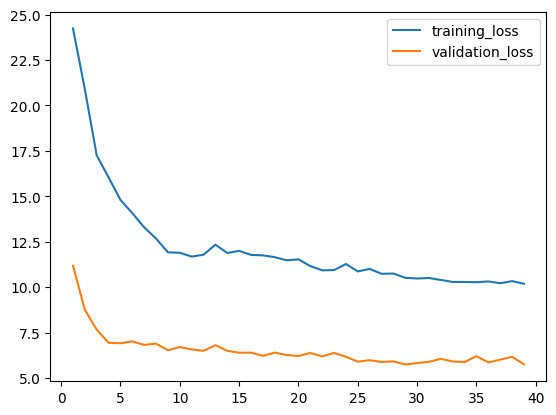

In [89]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

In [90]:
print(cp.best_model_path)
print(cp.best_model_score)
model = Autoencoder.load_from_checkpoint(cp.best_model_path)

/LUSTRE/home/ccd/VAE_anomalyHEP/checkpoints/epoch=28-step=136184.ckpt
tensor(5.7414)


### AE Result Visualization

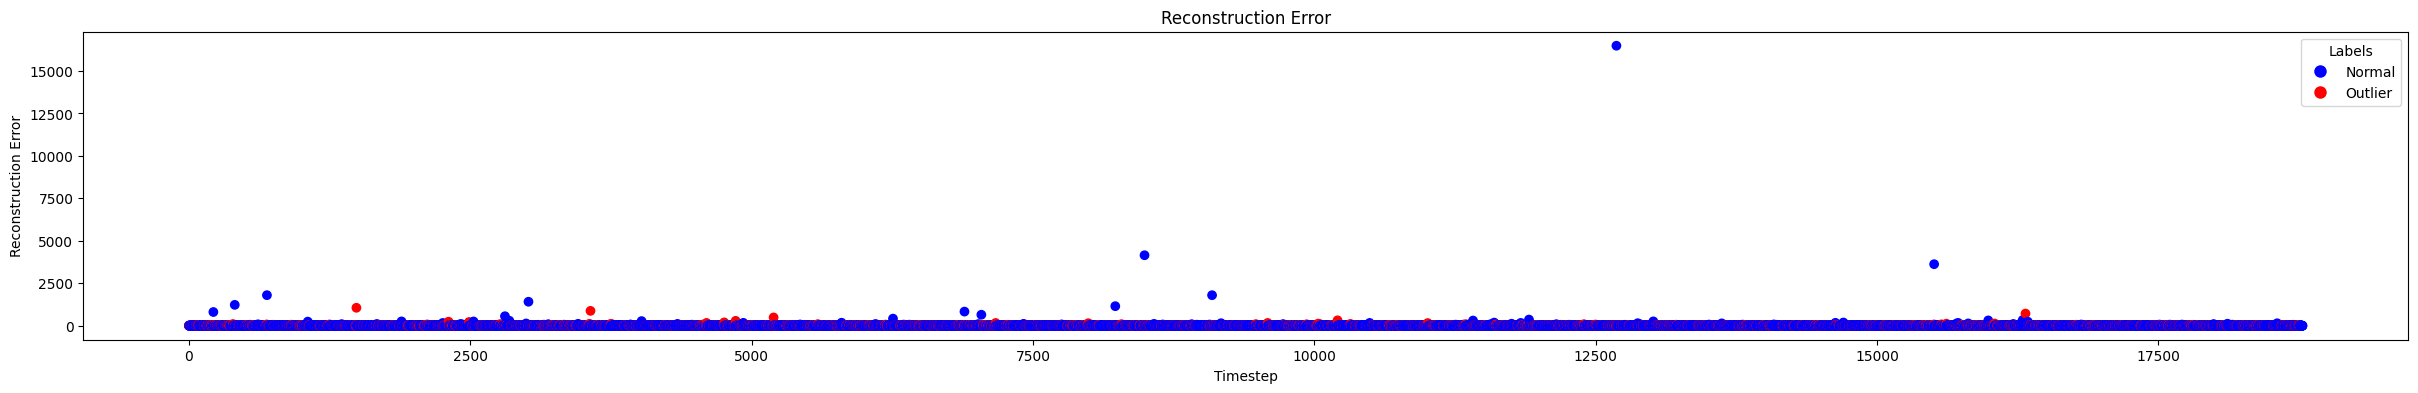

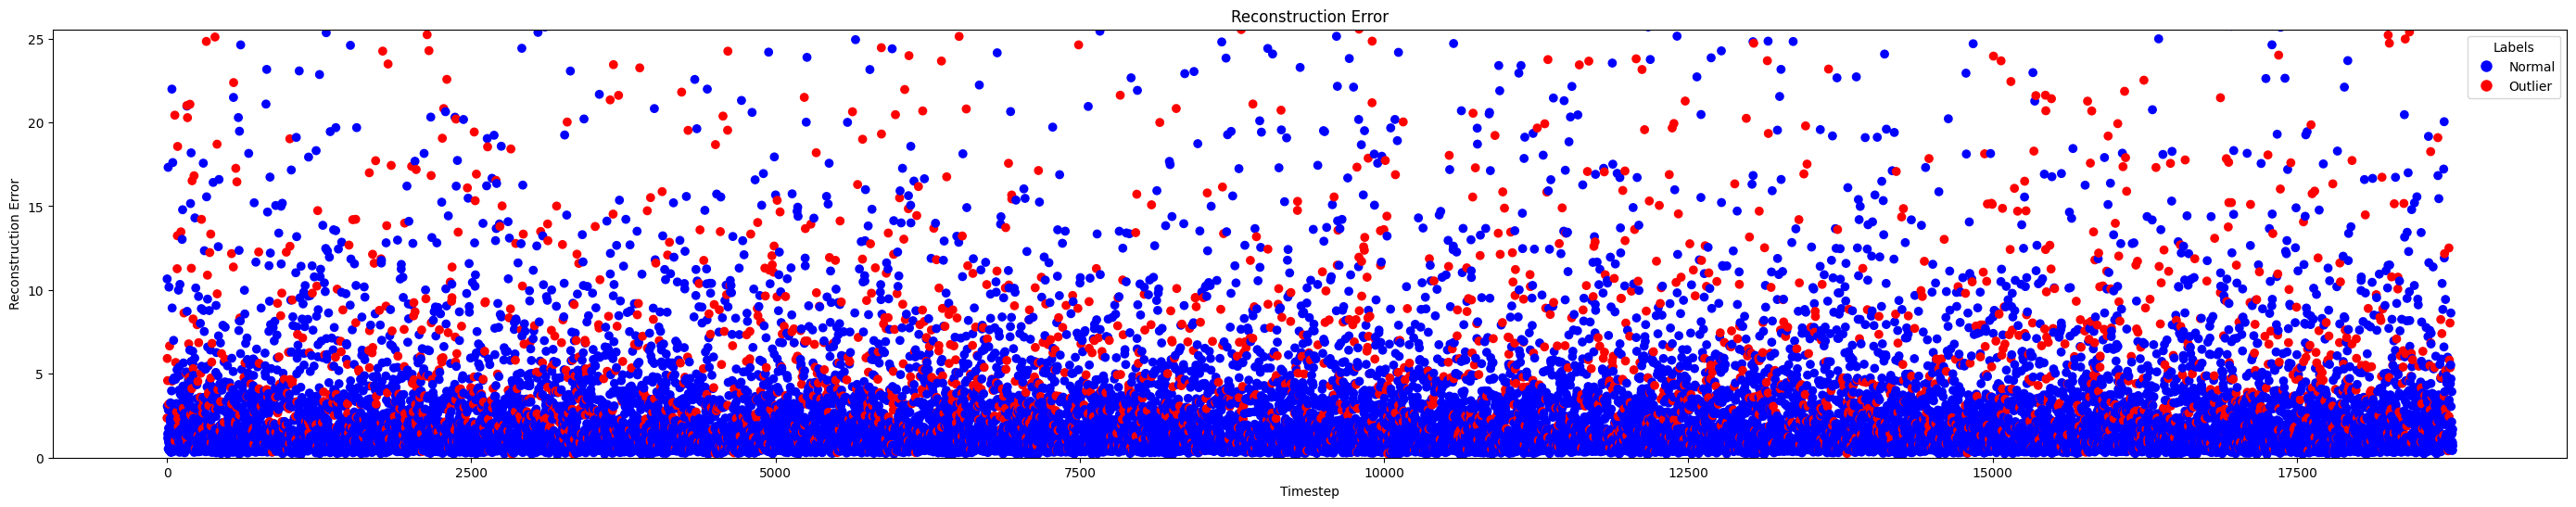

In [96]:
test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

## β-Variational Autoencoder
#### VAE: Pytorch Lightning Model Implementation
Weight for the Kullback–Leibler divergence of 0.5

In [101]:
class VariationalAutoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )
        
        self.fc_mu = nn.Linear(8, 8)
        self.fc_var = nn.Linear(8, 8)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

    def decode(self, z):
        result = self.decoder(z)
        return result

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparam(mu, log_var)
        return self.decode(z), input, mu, log_var

    def training_step(self, batch, batch_idx):

        input = batch
        output, _, mu, log_var = self.forward(input)
        loss = self.loss_fn(output, input, mu, log_var)
        self.log('train_loss', loss['loss'], prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):

        input = batch
        output, _, mu, log_var = self.forward(input)
        loss = self.loss_fn(output, input, mu, log_var)
        self.log('val_loss', loss['loss'], prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        return self.forward(input)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def loss_fn(self, *args, **kwargs) -> dict:

        recon = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = 0.5

        recon_loss = F.mse_loss(recon, input)
        kldiv_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recon_loss + kld_weight * kldiv_loss

        return {'loss': loss, 'rec': recon_loss.detach(), 'kld':-kldiv_loss.detach()}

### VAE Model Training

In [102]:
vae_train_ds = SensorDataset(X_train)
vae_valid_ds = SensorDataset(X_valid)
vae_test_ds = SensorDataset(X_test)

In [105]:
in_dim = ae_train_ds.dataset.shape[1]
model = VariationalAutoencoder(in_dim)

batch_size = 32
vae_tdl, vae_vdl = DataLoader(vae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(vae_valid_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()
trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=1_000, logger=False, enable_checkpointing=True, accelerator="cpu")
trainer.fit(model, train_dataloaders=vae_tdl, val_dataloaders=vae_vdl)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 1.7 K  | train
1 | fc_mu   | Linear     | 72     | train
2 | fc_var  | Linear     | 72     | train
3 | decoder | Sequential | 1.7 K  | train
-----------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
Epoch 25:  90%|████████▉ | 4204/4696 [00:26<00:03, 157.22it/s, loss=14.2265]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3

### Loss Curve

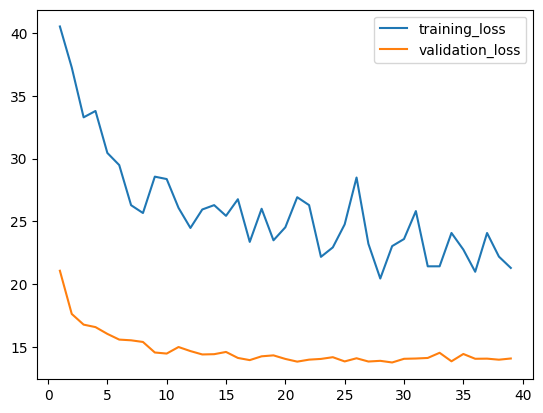

In [106]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

##### Best Model Retrieval (EarlyStopping)

In [107]:
print(cp.best_model_path)
print(cp.best_model_score)
model = VariationalAutoencoder.load_from_checkpoint(cp.best_model_path)

/LUSTRE/home/ccd/VAE_anomalyHEP/checkpoints/epoch=28-step=136184-v1.ckpt
tensor(13.7852)


#### VAE: Result Visualization

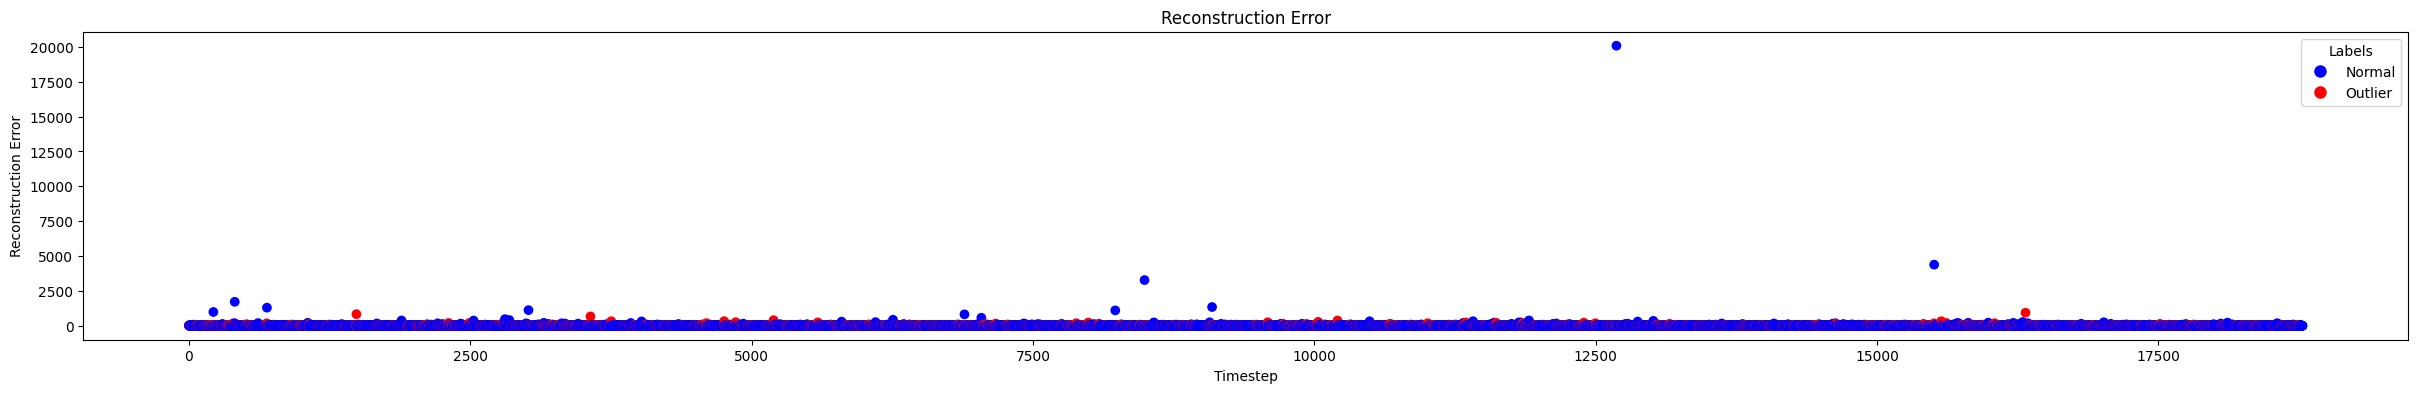

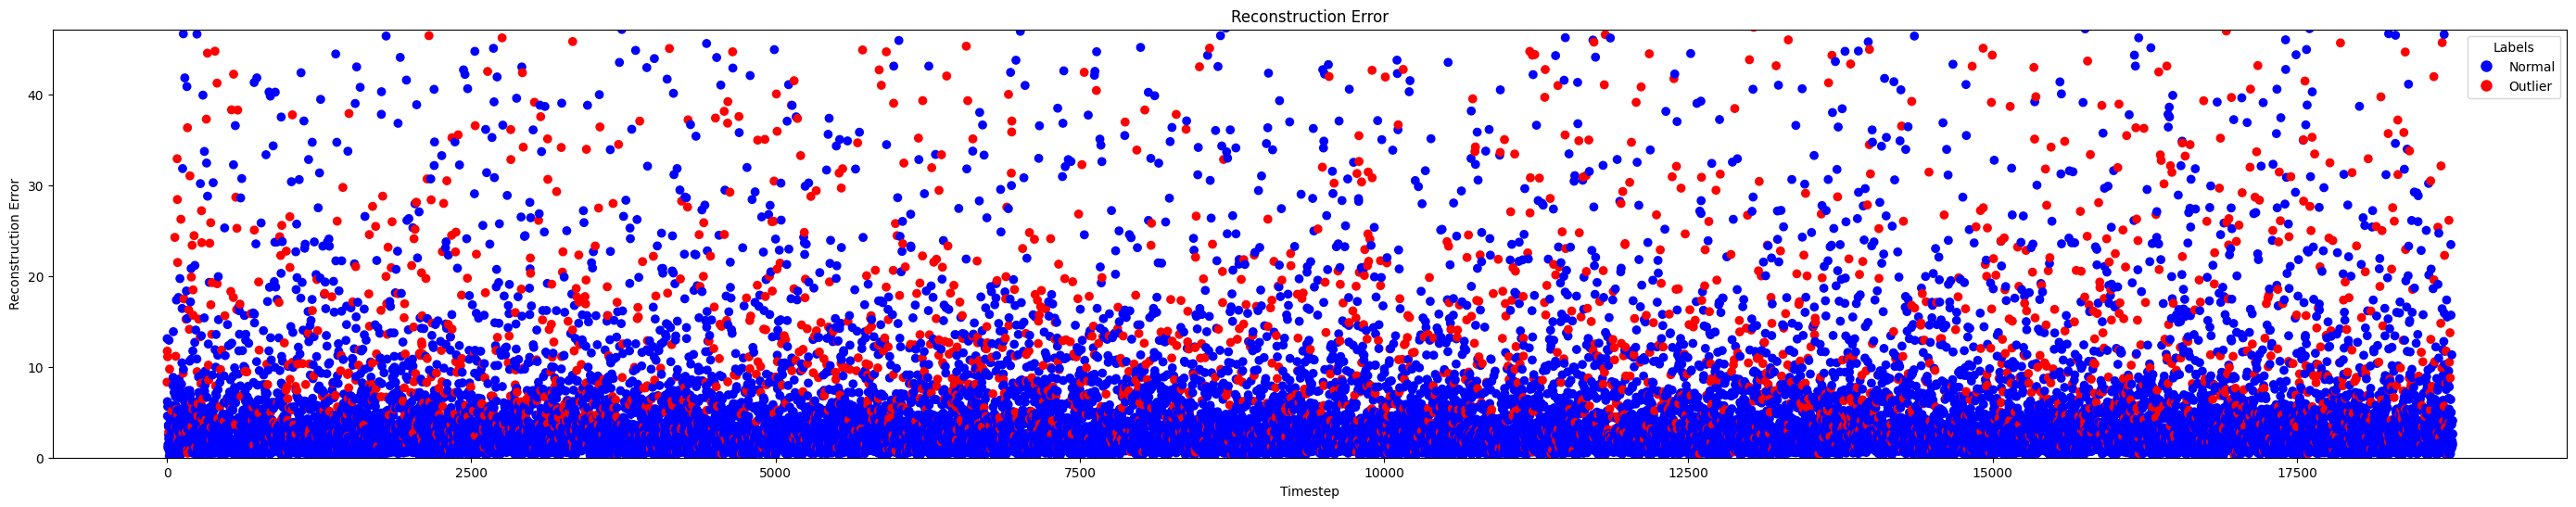

In [108]:
test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()